In [ ]:
# https://github.com/marcotcr/lime
# https://www.kaggle.com/prashant111/explain-your-model-predictions-with-lime?scriptVersionId=28590264
!pip install lime

In [1]:
import pandas as pd
import numpy as np
import boto3
import io
import os
import json
import random
import PIL.Image as Image
import datetime
import plotly.express as px
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import lime
import lime.lime_tabular
from lime import lime_image

import keras
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, LayerNormalization, GlobalAveragePooling2D, multiply, Conv2D, Conv1D, MaxPooling2D, Reshape, TimeDistributed, Input, LSTM, GRU, concatenate
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import np_utils, plot_model

Using TensorFlow backend.


In [2]:
tf.version.VERSION

'2.1.3'

**Load data**

In [3]:
# 40 for all
# 20 only for prices/volumes
# 2 for bid ask only
FEATURES = 20
batch_size = 32
CHANNELS = 1
window_size = 100 # 64 or 32 length LSTM

In [4]:
price_indices = np.concatenate([np.array(range(2,40,4))[::-1], np.array(range(0,40,4))])
volume_indices = np.concatenate([np.array(range(3,40,4))[::-1], np.array(range(1,40,4))])
spatial_ordering = np.dstack((price_indices, volume_indices)).flatten()
bid_ask_indices = [2, 0]

def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1[:, volume_indices])

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX.reshape(dataX.shape + (1,)), dataY
#     return dataX, dataY/

In [5]:
# please change the data_path to your local path
data_path = '../../FI-2010-lob-dataset/NoAuction/3.NoAuction_DecPre/'

dec_train = np.loadtxt(data_path + 'NoAuction_DecPre_Training/Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_test1 = np.loadtxt(data_path + 'NoAuction_DecPre_Testing/Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt(data_path + 'NoAuction_DecPre_Testing/Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt(data_path + 'NoAuction_DecPre_Testing/Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

In [6]:
# extract limit order book data from the FI-2010 dataset
train_lob = prepare_x(dec_train)
test_lob = prepare_x(dec_test)

# extract label from the FI-2010 dataset
train_label = get_label(dec_train)
test_label = get_label(dec_test)

# prepare training data. We feed past 100 observations into our algorithms and choose the prediction horizon. 
trainX_CNN, trainY_CNN = data_classification(train_lob, train_label, T=100)
trainY_CNN = trainY_CNN[:,4] - 1 # DeepLOB notation -> 0=10k, 1=20k, 2=30k, 3=50k, 4=100k
trainY_CNN = np_utils.to_categorical(trainY_CNN, 3)

# prepare test data.
testX_CNN, testY_CNN = data_classification(test_lob, test_label, T=100)
testY_CNN = testY_CNN[:,4] - 1
testY_CNN = np_utils.to_categorical(testY_CNN, 3)

In [7]:
train_lob.shape

(254750, 20)

**Define the model**

In [8]:
# For 2D channels
def SqueezeExcite2D(in_block, ch=32, ratio=4):
    x = GlobalAveragePooling2D()(in_block)
    x = Dense(ch//ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(x) # use_bias=False
    x = Dense(ch, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)
    return multiply([in_block, x])

def ConvBlock(_input):  # cleaner code
    x   = Conv1D(filters=10, kernel_size=3, padding='causal', use_bias=False,
                 kernel_initializer='lecun_normal')(_input)
    x   = BatchNormalization(scale=False)(x)
    x   = Activation('selu')(x)
    x   = AlphaDropout(0.1)(x)
    out = SqueezeExcite(x)    
    return out

# Only for 1D
def SqueezeExcite1D(_input, r=4):  # r == "reduction factor"; see paper
    filters = K.int_shape(_input)[-1]
    se = GlobalAveragePooling1D()(_input)
    se = Reshape((1, filters))(se)
    se = Dense(filters//r, activation='relu', use_bias=False, kernel_initializer='he_normal')(se)
    se = Dense(filters, activation='sigmoid', use_bias=False, kernel_initializer='he_normal')(se)
    return multiply([_input, se])

def inceptionModule(input_layer):
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(input_layer)
    convsecond_1 = tf.keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = tf.keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(input_layer)
    convsecond_2 = tf.keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = tf.keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(input_layer)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = tf.keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = tf.keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    return conv_reshape

# https://stackoverflow.com/questions/64792460/how-to-code-a-residual-block-using-two-layers-of-a-basic-cnn-algorithm-built-wit
# def resblock(x, kernelsize, filters):
#     fx1 = layers.Conv2D(filters, kernelsize, activation='relu', kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
#     fx1 = layers.BatchNormalization()(fx1)
#     fx2 = layers.Conv2D(filters, kernelsize, kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(fx1)
#     out = layers.Add()([x,fx2])
#     out = layers.ReLU()(out)
#     out = layers.BatchNormalization()(out)
#     return out

def resblock(x, kernelsize, filters):
    fx1 = layers.Conv2D(filters, kernelsize, kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
    fx1 = layers.Add()([x,fx1])
    fx1 = layers.ReLU()(fx1)
    fx1 = layers.BatchNormalization()(fx1)
    
    fx2 = layers.Conv2D(filters, kernelsize, kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(fx1)
    out = layers.Add()([x,fx2])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)
    return out

def make_residual_lstm_layers(input_layer, rnn_width, rnn_depth):
    """
    The intermediate LSTM layers return sequences, while the last returns a single element.
    The input is also a sequence. In order to match the shape of input and output of the LSTM
    to sum them we can do it only for all layers but the last.
    """
    x = input_layer
    for i in range(rnn_depth):
        return_sequences = i < rnn_depth - 1
        x_rnn = GRU(rnn_width, dropout=0.2, return_sequences=return_sequences, kernel_constraint=max_norm(3), recurrent_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
        if return_sequences:
            # Intermediate layers return sequences, input is also a sequence.
            if i > 0 or input_layer.shape[-1] == rnn_width:
                x = layers.add([x, x_rnn])
            else:
                # Note that the input size and RNN output has to match, due to the sum operation.
                # If we want different rnn_width, we'd have to perform the sum from layer 2 on.
                x = x_rnn
        else:
            # Last layer does not return sequences, just the last element
            # so we select only the last element of the previous output.
            def slice_last(x):
                return x[..., -1, :]
            x = layers.add([layers.Lambda(slice_last)(x), x_rnn])
    return x

In [9]:
def create_cnn_lstm_model(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
   
    #  spatial distribution learning
    conv_first1 = Conv2D(32, (1, 2), activation='relu', kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(input_lmd)
    conv_first1 = SqueezeExcite2D(conv_first1, 32)
    conv_first1 = resblock(conv_first1, (2, 1), 32)
    conv_first1 = Dropout(0.2, noise_shape=(conv_first1.shape[0],1,1,conv_first1.shape[3]))(conv_first1)
    
    conv_first1 = Conv2D(32, (1, 4), activation='relu', kernel_initializer='he_normal', padding='same', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(conv_first1)
    conv_first1 = SqueezeExcite2D(conv_first1, 32)
    conv_first1 = resblock(conv_first1, (4, 1), 32)
    conv_first1 = Dropout(0.2, noise_shape=(conv_first1.shape[0],1,1,conv_first1.shape[3]))(conv_first1)
   
    # strides=(1, 10),
    conv_first1 = Conv2D(32, (1, 10), activation='relu', strides=(1, 10), kernel_initializer='he_normal', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(conv_first1)
    conv_first1 = SqueezeExcite2D(conv_first1, 32)
    conv_first1 = resblock(conv_first1, (4, 1), 32)
    conv_first1 = Dropout(0.2, noise_shape=(conv_first1.shape[0],1,1,conv_first1.shape[3]))(conv_first1)
    
    conv_flat = Reshape((conv_first1.shape[1], conv_first1.shape[2]*conv_first1.shape[3]))(conv_first1)
    
    # build the last LSTM/ GRU layer
#     conv_lstm = LSTM(64, return_sequences=True, kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(conv_flat)
    # Residual LSTM: https://gist.github.com/bzamecnik/8ed16e361a0a6e80e2a4a259222f101e
    conv_lstm = make_residual_lstm_layers(conv_flat, 32, 3)

#     conv_lstm = attention()(conv_lstm)
    conv_lstm = BatchNormalization()(conv_lstm)
#     conv_lstm = Dropout(0.2)(conv_lstm)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = optimizers.Adam(lr=0.001, decay=0.001/40) 

#     model.load_weights('./weights/weights_no_images_28T.33-0.42.hdf5') # k=10, 32 all filters
#     model.load_weights('./weights/weights_no_images_22T.06-0.61.hdf5')    # k=20
#     model.load_weights('./weights/weights_no_images_23T.31-0.48.hdf5')	# k=50
    model.load_weights('../weights/weights_no_images_11T.42-0.42.hdf5')	# k=100

    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy'),
                                                                            tf.keras.metrics.CategoricalCrossentropy('categorical_crossentropy'),
#                                                                             f1_score,
#                                                                             recall,
#                                                                             precision,
#                                                                             MulticlassTruePositives(),
                                                                            tf.keras.metrics.Precision(name='precision'),
                                                                            tf.keras.metrics.Recall(name='recall')])

    return model

cnn_lstm_model = create_cnn_lstm_model(100, FEATURES, 64)
cnn_lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 20, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 20, 32)  96          input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 32)           0           conv2d[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            256         global_average_pooling2d[0][0]   
______________________________________________________________________________________________

**LIME analysis**

In [10]:
target_names = ['Up','Stationary', 'Down']
labels = [0, 1, 2]

In [11]:
trainX_CNN[0,:,:,0].shape

(100, 20)

In [12]:
np.array(list(range(1,21))).astype('str')

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'], dtype='<U21')

**Recurrent tabular explainer**

In [13]:
def new_predict_fn(images):
    images = images.reshape(images.shape + (1,))
    return cnn_lstm_model.predict(images)

In [14]:
# LIME has one explainer for all the models
explainer = lime.lime_tabular.RecurrentTabularExplainer(trainX_CNN[5000:6000,:,:,0], feature_names=np.array(list(range(1,21))).astype('str'),
                                                  class_names=target_names, verbose=True, mode='classification')

In [15]:
exp = explainer.explain_instance(trainX_CNN[100208,:,:,0], new_predict_fn, num_features=20, num_samples=5)

Intercept 0.03255527848683661
Prediction_local [0.01239443]
Right: 0.003735099


In [16]:
exp.show_in_notebook(show_table=True)

**RGB Image explainer**

In [17]:
from skimage import color
from skimage.segmentation import mark_boundaries

def new_predict_fn_images(images):
    images= color.rgb2gray(images)
    images = images.reshape(images.shape + (1,))
    return cnn_lstm_model.predict(images)

In [37]:
explainer_image = lime_image.LimeImageExplainer(kernel_width=0.25, verbose=True)

In [40]:
def explainInstanceFull(image2D, actualLabel):
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8,6))
    plt.subplot(4, 1, 1)
    plt.title('Original image (Real label = ' + target_names[actualLabel] + ')')
    plt.ylabel('price levels')
    plt.yticks([])
    plt.imshow(np.flip(image2D.T,0)) #  cmap='gray'
    fig.tight_layout()
#     plt.colorbar()
    
    explanation = explainer_image.explain_instance(image2D, new_predict_fn_images, top_labels=3, labels=target_names, hide_color=0, num_samples=200)
    
    for i in range(0, 3):
        plt.subplot(4, 1, i+2)
        plt.title(target_names[explanation.top_labels[i]])
        
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], positive_only=False, num_features=5)
        temp = mark_boundaries(temp / 2 + 0.8, mask)
        temp= color.rgb2gray(temp)
        plt.imshow(np.flip(np.array(temp).T,0))   
        plt.axis('off')
    
    fig.show()
    return explanation

  0%|          | 0/200 [00:00<?, ?it/s]

Intercept 0.003673761645969293
Prediction_local [0.00335159]
Right: 0.003356321
Intercept 0.9211968548110854
Prediction_local [0.02372145]
Right: 0.003735099
Intercept 0.07512934327233256
Prediction_local [0.97292697]
Right: 0.9929086


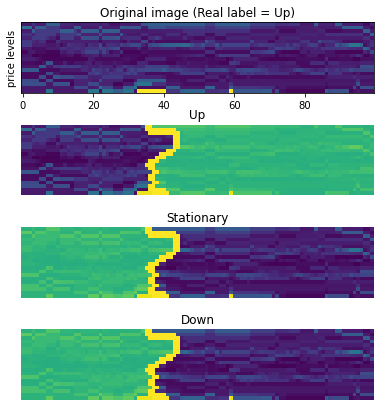

In [41]:
index = 100208
expl = explainInstanceFull(trainX_CNN[index,:,:,0], np.argmax(trainY_CNN[index], axis=0))

  0%|          | 0/200 [00:00<?, ?it/s]

Intercept 0.020207503068841164
Prediction_local [0.00073091]
Right: 0.0012678488
Intercept 0.9258235973213278
Prediction_local [0.0227621]
Right: 0.0016219412
Intercept 0.053968901727274976
Prediction_local [0.97650696]
Right: 0.9971102


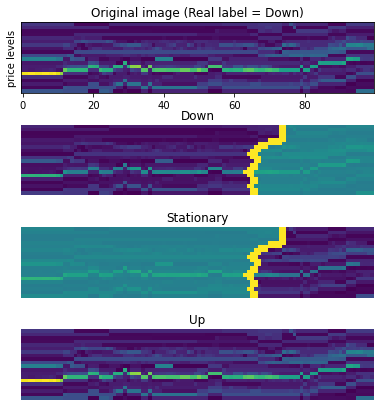

In [68]:
index = 108010
expl = explainInstanceFull(trainX_CNN[index,:,:,0], np.argmax(trainY_CNN[index], axis=0))

  0%|          | 0/200 [00:00<?, ?it/s]

Intercept 0.03378755756503485
Prediction_local [0.00728148]
Right: 0.0021184315
Intercept 0.909822851415248
Prediction_local [0.02456407]
Right: 0.0030795112
Intercept 0.05638953980799788
Prediction_local [0.96815448]
Right: 0.9948021


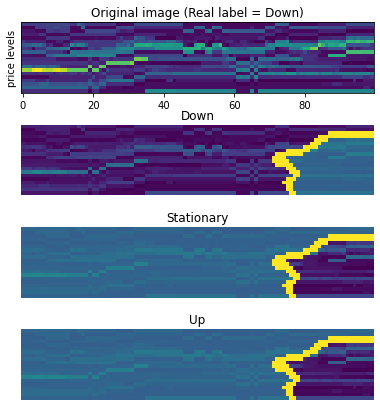

In [69]:
index = 108070
expl = explainInstanceFull(trainX_CNN[index,:,:,0], np.argmax(trainY_CNN[index], axis=0))

  0%|          | 0/200 [00:00<?, ?it/s]

Intercept 0.030587199378128337
Prediction_local [0.00232767]
Right: 0.0017135625
Intercept 0.7957486146520919
Prediction_local [0.01930905]
Right: 0.0024406577
Intercept 0.17366412856836244
Prediction_local [0.97836335]
Right: 0.99584585


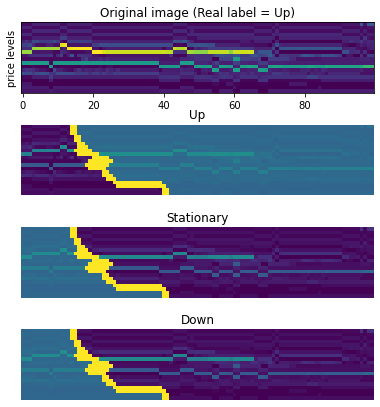

In [70]:
index = 109300
expl = explainInstanceFull(trainX_CNN[index,:,:,0], np.argmax(trainY_CNN[index], axis=0))

  0%|          | 0/200 [00:00<?, ?it/s]

Intercept 0.0028048036702377314
Prediction_local [0.02028832]
Right: 0.020639526
Intercept 0.03527341308807173
Prediction_local [0.03810687]
Right: 0.038195156
Intercept 0.9619217032174896
Prediction_local [0.94160476]
Right: 0.94116527


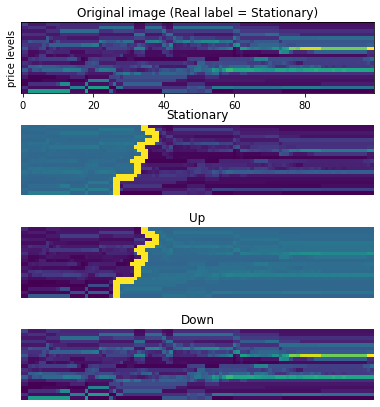

In [71]:
index = 80000
expl = explainInstanceFull(trainX_CNN[index,:,:,0], np.argmax(trainY_CNN[index], axis=0))

  0%|          | 0/200 [00:00<?, ?it/s]

Intercept 0.0204285317514863
Prediction_local [0.01932621]
Right: 0.019307224
Intercept 0.08127142389203326
Prediction_local [0.04539202]
Right: 0.044668444
Intercept 0.8983002008387414
Prediction_local [0.93528181]
Right: 0.93602437


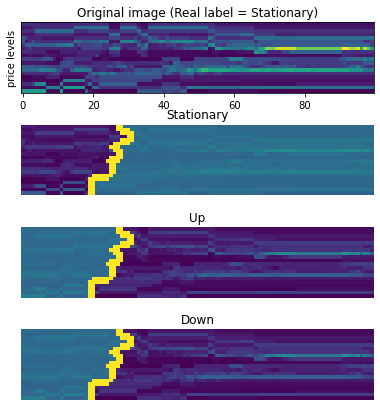

In [72]:
index = 80007
expl = explainInstanceFull(trainX_CNN[index,:,:,0], np.argmax(trainY_CNN[index], axis=0))

In [297]:
trainY_CNN[80000:80050]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1

**Print variables**

In [67]:
from pprint import pprint
pprint(vars(expl))

{'image': array([[[0.01984, 0.01984, 0.01984],
        [0.02012, 0.02012, 0.02012],
        [0.06219, 0.06219, 0.06219],
        ...,
        [0.02083, 0.02083, 0.02083],
        [0.09325, 0.09325, 0.09325],
        [0.019  , 0.019  , 0.019  ]],

       [[0.01984, 0.01984, 0.01984],
        [0.02012, 0.02012, 0.02012],
        [0.06219, 0.06219, 0.06219],
        ...,
        [0.02083, 0.02083, 0.02083],
        [0.09325, 0.09325, 0.09325],
        [0.019  , 0.019  , 0.019  ]],

       [[0.01984, 0.01984, 0.01984],
        [0.02012, 0.02012, 0.02012],
        [0.06219, 0.06219, 0.06219],
        ...,
        [0.02083, 0.02083, 0.02083],
        [0.09325, 0.09325, 0.09325],
        [0.019  , 0.019  , 0.019  ]],

       ...,

       [[0.01267, 0.01267, 0.01267],
        [0.06219, 0.06219, 0.06219],
        [0.01984, 0.01984, 0.01984],
        ...,
        [0.07614, 0.07614, 0.07614],
        [0.0224 , 0.0224 , 0.0224 ],
        [0.00909, 0.00909, 0.00909]],

       [[0.01267, 0.01267, 0.

In [76]:
expl.local_pred # This is a bug, it should show probs for all the classes

array([0.93528181])